# SHAP (SHapley Additive exPlanations)

Our final algorithm of the day: SHAP. Again, we can utilize a dedicated python library for this **shap**. 

The first four cells are already known from the previous notebook.

In [1]:
import torch
from torchvision import models, transforms
import numpy as np
import medmnist
import matplotlib.cm as cm
from torch.utils.data import DataLoader
from skimage.segmentation import slic

import torch.nn.functional as F
import matplotlib.pyplot as plt

import shap

C:\Users\jung\anaconda3\envs\computer_vision\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18()
model.fc = torch.nn.Linear(model.fc.in_features, 7)
model.load_state_dict(torch.load("../Exercise/best_dermamnist_resnet_model.pth", map_location=device))

<All keys matched successfully>

In [3]:
data_flag = 'dermamnist'
info = medmnist.INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

mean = 0.5
std = 0.5
batch_size = 128

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

test_dataset = DataClass(split='test', transform=data_transform, size=64, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

In [4]:
images, labels = next(iter(test_loader))
images = images.to(device)

## **Applying SHapley Additive exPlanations**

In [6]:
# Set class labels (shortend for plotting later)
class_labels = [
    'actinic keratoses', 'basal cell carcinoma', 'benign keratosis-like',
    'dermatofibroma', 'melanoma', 'melanocytic nevi', 'vascular lesions'
]

Similar to lime, we need to select an image and bring it in the right format:

In [13]:
# Select the image
image_idx_to_explain = 10
img_tensor_norm = images[image_idx_to_explain].unsqueeze(0)
img_numpy_unnorm = img_tensor_norm.permute(0, 2, 3, 1).cpu().numpy() * std + mean


And a model wrapper as in the lime notebook:

In [16]:
# To Do
# Write (or copy) batch_predict function as in the previous notebook


Then we can bring all together:

In [19]:
masker = shap.maskers.Image("blur(16, 16)", img_numpy_unnorm[0].shape)
explainer = shap.Explainer(batch_predict, masker, output_names=class_labels)

# Calculate SHAP values using the NumPy array
shap_values = explainer(
    img_numpy_unnorm, # <-- Pass the NumPy array here
    max_evals=500,
    batch_size=50,
    outputs=shap.Explanation.argsort.flip[:5]
)

Plot the results:


SHAP explanation:


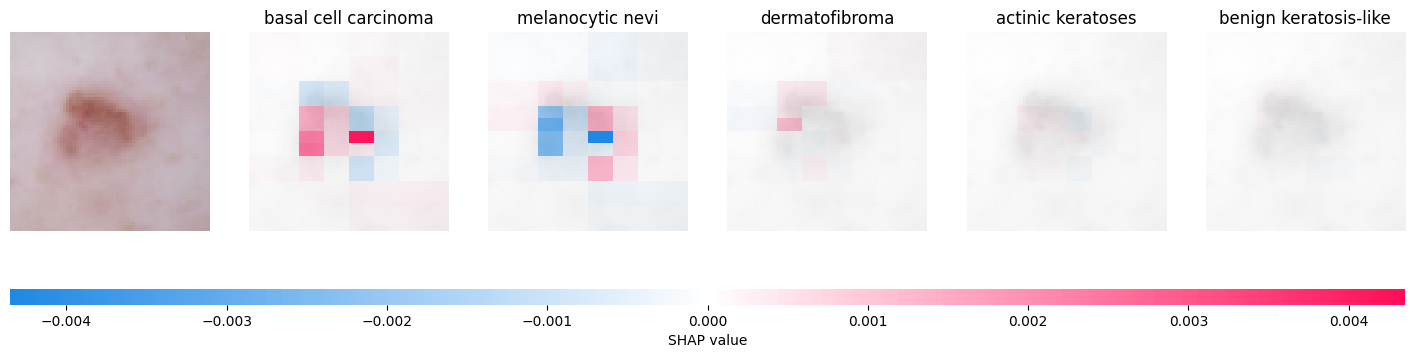

In [21]:
# Plot the results
print("\nSHAP explanation:")
shap.image_plot(shap_values)